In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
Tamano de la serie temporal 2
shape train/val (17396, 96, 1, 1) (8659, 96, 1, 1) (8587, 96, 1, 1)
(17396, 96, 1, 1)
/home/blasting/TFG_TimeSeries/notebooks/utils.py:133: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/bl

In [3]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [4]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = Dense(input_shape[0][-1], 
                input_shape=input_shape, 
                kernel_initializer='glorot_uniform', 
                bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[n_head](inputs) for n_head in range (self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [5]:
def create_model(d_k=256, d_v=256, n_heads=12, ff_dim=256, time2vec_dim=42, n_transfomerencoder=3, n_dense_layers=1, n_neurons_dense_layer=64, dropout_rate=0.1):
    '''Initialize time and transformer layers'''
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    """attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)"""

    '''Construct model'''

    inputs = tfk.layers.Input(shape=(X_train.shape[1],          X_train.shape[2]))
    time2vec = T2V(time2vec_dim)(inputs)
    x = attn_layer1((time2vec, time2vec, time2vec))
    #x = attn_layer2((x, x, x))
    #x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(y_train.shape[1], activation='linear')(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()


history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=35, 
                    validation_data=(X_val, y_val))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
t2v (T2V)                       (None, 96, 43)       4266        input_1[0][0]                    
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 96, 43)       560130      t2v[0][0]                        
                                                                 t2v[0][0]                        
                                                                 t2v[0][0]                        
______________________________________________________________________________________________

In [ ]:
history2 = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=35, 
                    validation_data=(X_val, y_val))

In [9]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)

y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test2, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val2, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [11]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [12]:
print("test")
evaluate_forecasts(y_test2, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val2, y_hat_2, 6)

test
t+1 MSE: 328.489920
t+2 MSE: 393.228582
t+3 MSE: 429.593972
t+4 MSE: 477.786698
t+5 MSE: 528.869682
t+6 MSE: 574.930147
validacion
t+1 MSE: 332.980256
t+2 MSE: 395.077886
t+3 MSE: 428.455424
t+4 MSE: 471.297437
t+5 MSE: 519.834489
t+6 MSE: 572.233705


In [14]:
(328.489920 + 393.228582 + 429.593972 + 477.786698 + 528.869682 + 574.930147)/6

455.4831668333333

In [17]:
y_hat_2[:, 1].shape

(8659,)

In [18]:
X_val[:144+seq_len, 3].shape

(240, 1)

In [127]:
X_val.shape[0]

8659

In [98]:
plt.style.use('science')


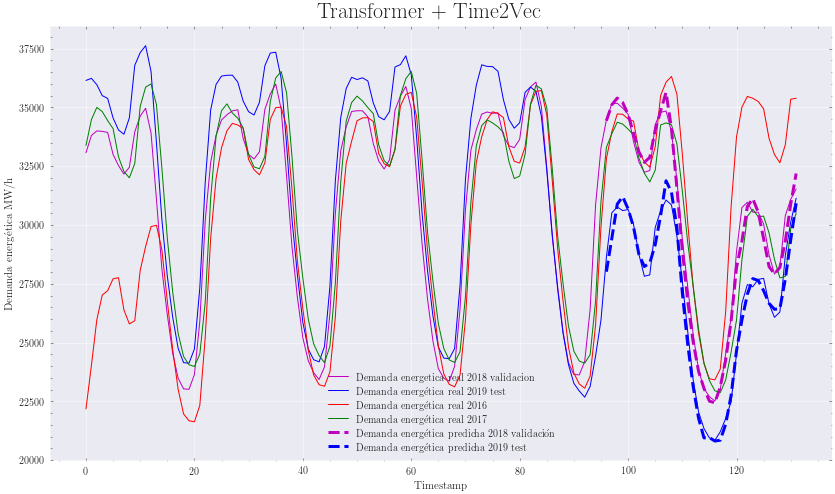

In [125]:
seq_len = 96
horizonte_pred = 36
n_init_seq = X_val.shape[0]-7*(horizonte_pred+seq_len)
fig = plt.figure(figsize=(14,8))
st = fig.suptitle("Transformer + Time2Vec", fontsize=22)
st.set_y(0.92)
#Plot validation data results
plt.plot(scaler.inverse_transform(X_val[n_init_seq:n_init_seq+(horizonte_pred+seq_len), 1]), 'm', label='Demanda energetica real 2018 validacion')
plt.plot(scaler.inverse_transform(X_test[n_init_seq:n_init_seq+(horizonte_pred+seq_len), 1]), 'b', label='Demanda energética real 2019 test')
plt.plot(scaler.inverse_transform(X_train[n_init_seq:n_init_seq+(horizonte_pred+seq_len), 1]),'r', label='Demanda energética real 2016')
plt.plot(scaler.inverse_transform(X_train[n_init_seq+8760:n_init_seq+8760+(horizonte_pred+seq_len), 1]), 'g', label='Demanda energética real 2017')
plt.plot(np.arange(seq_len, horizonte_pred+seq_len), y_hat_2[n_init_seq:n_init_seq+horizonte_pred, 1],'m--', linewidth=3, label='Demanda energética predicha 2018 validación')
plt.plot(np.arange(seq_len, horizonte_pred+seq_len), y_hat[n_init_seq:n_init_seq+horizonte_pred, 1],'b--', linewidth=3, label='Demanda energética predicha 2019 test')
#plt.set_title("Validation Data", fontsize=18)
plt.xlabel('Timestamp')
plt.ylabel('Demanda energética MW/h')
plt.legend(loc="best", fontsize=10)

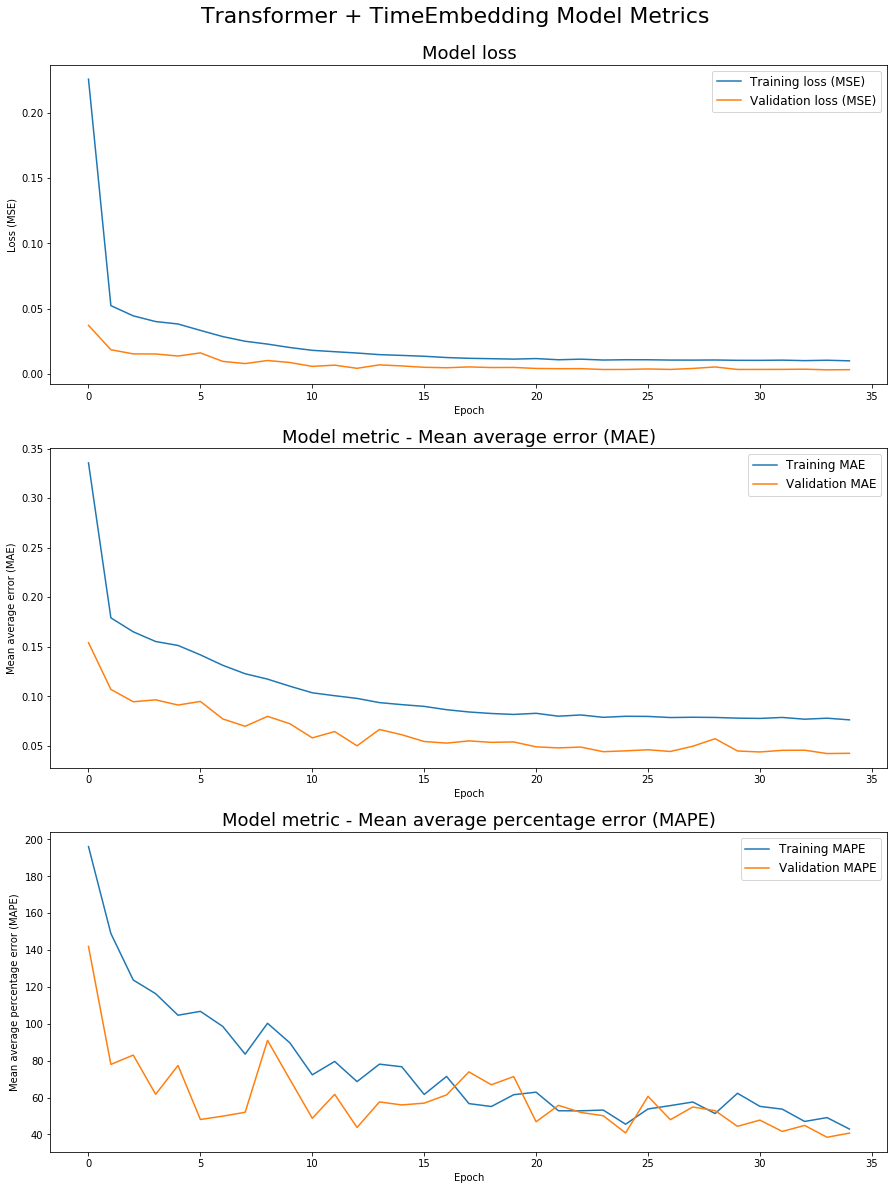

In [19]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)